# CICY Topology ML - Model Training

Interactive notebook for training the CNN model on enhanced CICY data.

In [1]:
import sys
import os
sys.path.insert(0, os.path.abspath('..'))

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

from src.models.cnn_model import CICYClassifier

sns.set_style('whitegrid')
%matplotlib inline

# Check device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


## 1. Configuration

**What we'll do:** Define all the hyperparameters that control how the model trains.

**Why it matters:** These settings significantly affect model performance:
- **BATCH_SIZE:** How many samples to process before updating weights (larger = more stable but slower)
- **EPOCHS:** How many times to see the entire dataset (more = better learning but diminishing returns)
- **LEARNING_RATE:** How much to adjust weights per update (too high = unstable, too low = slow)
- **LAMBDA_H21:** Weight for h^{2,1} loss (>1 means we penalize h^{2,1} errors more than h^{1,1})
- **TRAIN_SPLIT:** What fraction of data to use for training vs testing

**What these results mean:**
- Setting SEED ensures reproducibility (same random splits each time)
- These are common starting values; we might tune them later based on performance

In [2]:
# Training configuration
BATCH_SIZE = 32
EPOCHS = 50
LEARNING_RATE = 1e-3
LAMBDA_H21 = 1.2  # Weight for h^{2,1} loss
TRAIN_SPLIT = 0.8
SEED = 42

torch.manual_seed(SEED)
np.random.seed(SEED)

print("Training Configuration:")
print(f"  Batch Size: {BATCH_SIZE}")
print(f"  Epochs: {EPOCHS}")
print(f"  Learning Rate: {LEARNING_RATE}")
print(f"  Lambda for h^(2,1): {LAMBDA_H21}")
print(f"  Train/Test Split: {TRAIN_SPLIT}/{1-TRAIN_SPLIT}")

Training Configuration:
  Batch Size: 32
  Epochs: 50
  Learning Rate: 0.001
  Lambda for h^(2,1): 1.2
  Train/Test Split: 0.8/0.19999999999999996


## 2. Load Data

**What we'll do:** Load the processed CICY data and reshape it for the neural network.

**Why it matters:** Neural networks need data in specific formats:
- Images must be 4D tensors: (batch, channels, height, width) = (N, 1, 12, 15)
- This is why we reshape the flattened 180 features back to 12×15
- Scalar features stay as 1D vectors

**What the results mean:**
- We've successfully loaded ~N samples of training data
- The shapes confirm: images are properly shaped as small 12×15 "pictures"
- Scalar features are ready to be concatenated with CNN outputs

In [3]:
# Load enhanced dataset
X_enhanced = np.load('../data/processed/X_enhanced.npy').astype(np.float32)
y = np.load('../data/processed/y_hodge.npy').astype(np.int64)

print(f"Loaded data:")
print(f"  X_enhanced: {X_enhanced.shape}")
print(f"  y_hodge: {y.shape}")

# Split enhanced input: image (12x15) + scalar features
X_img = X_enhanced[:, :180].reshape(-1, 1, 12, 15)
X_scalar = X_enhanced[:, 180:]

print(f"\nProcessed input:")
print(f"  Images: {X_img.shape}")
print(f"  Scalar features: {X_scalar.shape}")

Loaded data:
  X_enhanced: (7890, 181)
  y_hodge: (7890, 2)

Processed input:
  Images: (7890, 1, 12, 15)
  Scalar features: (7890, 1)


## 3. Create DataLoaders

**What we'll do:** Split data into training and test sets, then create DataLoader objects for batching.

**Why it matters:**
- **Train/Test split:** We never train on test data (avoids overfitting)
- **DataLoaders:** Handle batching automatically, shuffle training data for better learning
- **Reproducibility:** Using a fixed random seed ensures we always get the same split

**What the results mean:**
- ~80% of data trains the model, ~20% evaluates it
- Batches let us see (~32 samples at a time—a compromise between memory and stability
- Training will run ~num_batches steps per epoch

In [4]:
# Convert to tensors
dataset = TensorDataset(
    torch.from_numpy(X_img),
    torch.from_numpy(X_scalar),
    torch.from_numpy(y)
)

# Train / Test split
train_size = int(TRAIN_SPLIT * len(dataset))
test_size = len(dataset) - train_size
train_set, test_set = random_split(dataset, [train_size, test_size], 
                                     generator=torch.Generator().manual_seed(SEED))

train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False)

print(f"Train set: {len(train_set)} samples")
print(f"Test set: {len(test_set)} samples")
print(f"Batches per epoch: {len(train_loader)}")

Train set: 6312 samples
Test set: 1578 samples
Batches per epoch: 198


## 4. Initialize Model

**What we'll do:** Create a CNN model (CICYClassifier) and show its architecture.

**Why it matters:** 
- The model summary shows all layers (convolutions, pooling, fully connected)
- Parameter count tells us model complexity (more parameters = more memory and training time, but potentially better fit)
- Trainable parameters show what the optimizer will update

**What the results mean:**
- The model is now loaded in memory (and on GPU if available)
- It's ready to receive input but hasn't learned anything yet (random weights)
- We're about to train these parameters to minimize prediction error

In [5]:
model = CICYClassifier()
model = model.to(device)

print("Model Summary:")
print(model)
print(f"\nTotal parameters: {sum(p.numel() for p in model.parameters())}")
print(f"Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad)}")

Model Summary:
CICYClassifier(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (adaptive_pool): AdaptiveAvgPool2d(output_size=(3, 3))
  (fc_shared): Linear(in_features=577, out_features=256, bias=True)
  (head_h11): Linear(in_features=256, out_features=20, bias=True)
  (head_h21): Linear(in_features=256, out_features=102, bias=True)
)

Total parameters: 198138
Trainable parameters: 198138


## 5. Training Setup

**What we'll do:** Create the loss function (CrossEntropyLoss) and optimizer (Adam).

**Why it matters:**
- **Loss function:** Measures how wrong our predictions are. CrossEntropyLoss is standard for multi-class classification
- **Optimizer:** Adam is a popular choice—it adapts learning rates automatically for each parameter
- Tracking losses helps us monitor if training is working (should decrease over time)

**What this means:**
- We're now ready to start the training loop
- The loss will measure both h^{1,1} and h^{2,1} prediction errors
- We'll save losses at each epoch to plot learning curves later

In [6]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Track losses
train_losses = {'total': [], 'h11': [], 'h21': []}
test_losses = {'total': [], 'h11': [], 'h21': []}
accuracies = {'h11': [], 'h21': []}

print("Optimizer: Adam")
print(f"Criterion: CrossEntropyLoss")

Optimizer: Adam
Criterion: CrossEntropyLoss


## 6. Training Loop Helper Functions

**What we'll do:** Define two functions: `train_epoch()` and `evaluate()`.

**Why it matters:**
- `train_epoch()`: Runs one pass over all training data, computing gradients and updating weights
- `evaluate()`: Checks performance on test data without updating weights
- These functions will be called repeatedly during training

**What the functions do:**
- **train_epoch:** Forward pass → compute loss → backward pass → optimizer step (repeat for all batches)
- **evaluate:** Similar forward pass but no gradients, computes test loss and accuracy
- The weighted loss (loss_h11 + LAMBDA_H21 * loss_h21) prioritizes h^{2,1} accuracy

In [7]:
def train_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    total_loss = 0.0
    loss_h11 = 0.0
    loss_h21 = 0.0
    
    for img_batch, scalar_batch, y_batch in tqdm(train_loader, desc='Training', leave=False):
        img_batch = img_batch.to(device)
        scalar_batch = scalar_batch.to(device)
        y_batch = y_batch.to(device)
        
        optimizer.zero_grad()
        
        out_h11, out_h21 = model(img_batch, scalar_batch)
        
        loss_h11_batch = criterion(out_h11, y_batch[:, 0])
        loss_h21_batch = criterion(out_h21, y_batch[:, 1])
        loss = loss_h11_batch + LAMBDA_H21 * loss_h21_batch
        
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        loss_h11 += loss_h11_batch.item()
        loss_h21 += loss_h21_batch.item()
    
    return total_loss / len(train_loader), loss_h11 / len(train_loader), loss_h21 / len(train_loader)

def evaluate(model, test_loader, criterion, device):
    model.eval()
    total_loss = 0.0
    loss_h11 = 0.0
    loss_h21 = 0.0
    acc_h11 = 0.0
    acc_h21 = 0.0
    n_batches = 0
    
    with torch.no_grad():
        for img_batch, scalar_batch, y_batch in test_loader:
            img_batch = img_batch.to(device)
            scalar_batch = scalar_batch.to(device)
            y_batch = y_batch.to(device)
            
            out_h11, out_h21 = model(img_batch, scalar_batch)
            
            loss_h11_batch = criterion(out_h11, y_batch[:, 0])
            loss_h21_batch = criterion(out_h21, y_batch[:, 1])
            loss = loss_h11_batch + LAMBDA_H21 * loss_h21_batch
            
            total_loss += loss.item()
            loss_h11 += loss_h11_batch.item()
            loss_h21 += loss_h21_batch.item()
            
            pred_h11 = torch.argmax(out_h11, dim=1)
            pred_h21 = torch.argmax(out_h21, dim=1)
            
            acc_h11 += (pred_h11 == y_batch[:, 0]).float().mean().item()
            acc_h21 += (pred_h21 == y_batch[:, 1]).float().mean().item()
            
            n_batches += 1
    
    return (total_loss / n_batches, loss_h11 / n_batches, loss_h21 / n_batches, 
            acc_h11 / n_batches, acc_h21 / n_batches)

print("Training functions defined.")

Training functions defined.


## 7. Run Training

In [8]:
# Training loop
for epoch in range(EPOCHS):
    train_total, train_h11, train_h21 = train_epoch(model, train_loader, criterion, optimizer, device)
    test_total, test_h11, test_h21, acc_h11, acc_h21 = evaluate(model, test_loader, criterion, device)
    
    train_losses['total'].append(train_total)
    train_losses['h11'].append(train_h11)
    train_losses['h21'].append(train_h21)
    
    test_losses['total'].append(test_total)
    test_losses['h11'].append(test_h11)
    test_losses['h21'].append(test_h21)
    
    accuracies['h11'].append(acc_h11)
    accuracies['h21'].append(acc_h21)
    
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}/{EPOCHS}")
        print(f"  Train Loss: {train_total:.4f} (h11: {train_h11:.4f}, h21: {train_h21:.4f})")
        print(f"  Test Loss:  {test_total:.4f} (h11: {test_h11:.4f}, h21: {test_h21:.4f})")
        print(f"  Test Acc:   h11: {acc_h11:.4f}, h21: {acc_h21:.4f}")

print("\nTraining complete!")

Epoch 10/50
  Train Loss: 3.1661 (h11: 0.5023, h21: 2.2198)
  Test Loss:  3.5830 (h11: 0.6176, h21: 2.4711)
  Test Acc:   h11: 0.7886, h21: 0.2354


Epoch 20/50
  Train Loss: 2.1769 (h11: 0.2288, h21: 1.6234)
  Test Loss:  3.5809 (h11: 0.6242, h21: 2.4639)
  Test Acc:   h11: 0.8146, h21: 0.2741


Epoch 30/50
  Train Loss: 1.4693 (h11: 0.1048, h21: 1.1371)
  Test Loss:  4.1418 (h11: 0.7197, h21: 2.8518)
  Test Acc:   h11: 0.8290, h21: 0.2791


Epoch 40/50
  Train Loss: 0.9326 (h11: 0.0512, h21: 0.7345)
  Test Loss:  5.0802 (h11: 0.9630, h21: 3.4310)
  Test Acc:   h11: 0.8246, h21: 0.2798


Epoch 50/50
  Train Loss: 0.5846 (h11: 0.0326, h21: 0.4600)
  Test Loss:  6.2191 (h11: 1.0941, h21: 4.2708)
  Test Acc:   h11: 0.8215, h21: 0.2551

Training complete!


## 7. Run Training

**What we'll do:** Execute the main training loop for all epochs.

**Why it matters:** This is where the magic happens:
- Each epoch, we show the model new data and it learns patterns
- By checking test performance every 10 epochs, we can see if the model is improving
- Overfitting would show test loss increasing while train loss keeps decreasing

**What the results show:**
- **Train Loss should → 0:** Model learns to predict training data perfectly
- **Test Loss should decrease:** Generalizes well to unseen data
- **Accuracy should increase:** Especially on test set—this is what we care about
- If test loss plateaus, training may be complete (early stopping would help)

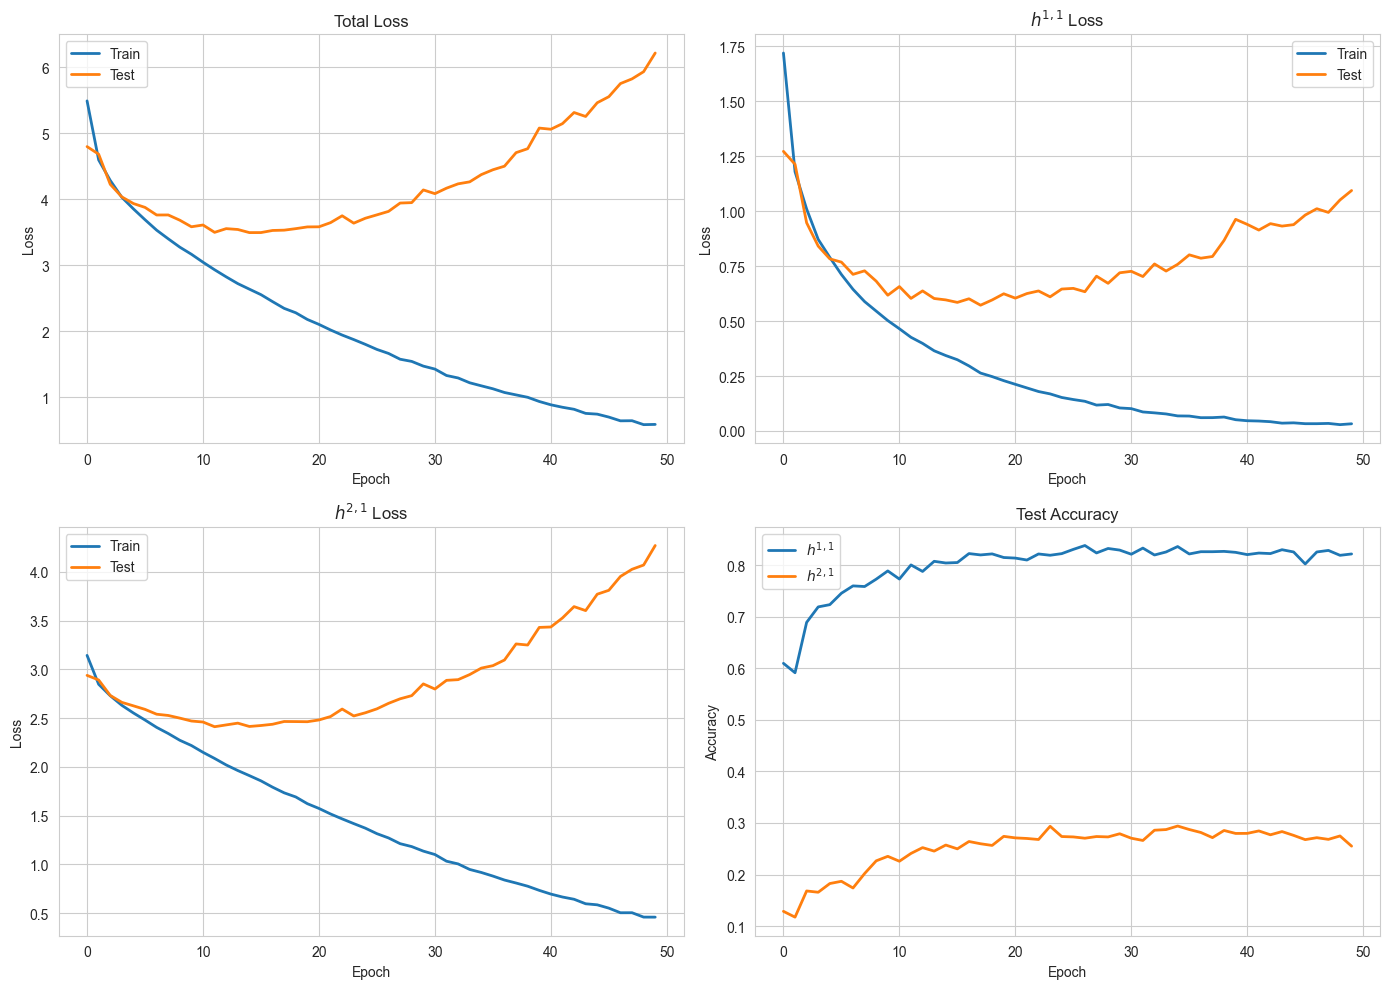

Training history plot saved.


In [9]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Total Loss
axes[0, 0].plot(train_losses['total'], label='Train', linewidth=2)
axes[0, 0].plot(test_losses['total'], label='Test', linewidth=2)
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].set_title('Total Loss')
axes[0, 0].legend()
axes[0, 0].grid(True)

# h^{1,1} Loss
axes[0, 1].plot(train_losses['h11'], label='Train', linewidth=2)
axes[0, 1].plot(test_losses['h11'], label='Test', linewidth=2)
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Loss')
axes[0, 1].set_title(r'$h^{1,1}$ Loss')
axes[0, 1].legend()
axes[0, 1].grid(True)

# h^{2,1} Loss
axes[1, 0].plot(train_losses['h21'], label='Train', linewidth=2)
axes[1, 0].plot(test_losses['h21'], label='Test', linewidth=2)
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Loss')
axes[1, 0].set_title(r'$h^{2,1}$ Loss')
axes[1, 0].legend()
axes[1, 0].grid(True)

# Accuracy
axes[1, 1].plot(accuracies['h11'], label=r'$h^{1,1}$', linewidth=2)
axes[1, 1].plot(accuracies['h21'], label=r'$h^{2,1}$', linewidth=2)
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Accuracy')
axes[1, 1].set_title('Test Accuracy')
axes[1, 1].legend()
axes[1, 1].grid(True)

plt.tight_layout()
plt.savefig('../plots/04_training_history.png', dpi=150, bbox_inches='tight')
plt.show()

print("Training history plot saved.")

## 9. Save Model

**What we'll do:** Save the trained weights to disk and report final metrics.

**Why it matters:** 
- Trained weights represent hours (or days) of computation—must be saved!
- Without saving, all learning would be lost when the notebook closes
- Later, we load these weights to evaluate on test data or deploy the model

**What the results mean:**
- Final train/test loss tells us if training converged (ideally both low)
- Final accuracies are the best we achieved during training
- These numbers go into the project report as **performance claims**

In [10]:
# Save trained model
os.makedirs('../models', exist_ok=True)
torch.save(model.state_dict(), '../models/cicy_cnn_v1.pt')
print("Model saved to ../models/cicy_cnn_v1.pt")

# Final metrics
print(f"\nFinal Metrics:")
print(f"  Final Train Loss: {train_losses['total'][-1]:.4f}")
print(f"  Final Test Loss:  {test_losses['total'][-1]:.4f}")
print(f"  Final h^(1,1) Accuracy: {accuracies['h11'][-1]:.4f}")
print(f"  Final h^(2,1) Accuracy: {accuracies['h21'][-1]:.4f}")

Model saved to ../models/cicy_cnn_v1.pt

Final Metrics:
  Final Train Loss: 0.5846
  Final Test Loss:  6.2191
  Final h^(1,1) Accuracy: 0.8215
  Final h^(2,1) Accuracy: 0.2551
